In [1]:
from pathlib import Path
import pandas as pd

In [58]:
data_dir = Path("/home/mpecovnik/Private/sentiment-analysis/data/twitter")

full_df = []

for coin_path in data_dir.iterdir():    
    coin_name = coin_path.name
    
    coin_df = pd.concat(
        pd.read_parquet(parquet_file)
        for parquet_file in coin_path.glob('*.parquet')
    )
    
    coin_df.loc[:, "coin"] = str(coin_name)
    
    full_df.append(coin_df)
    
full_df = pd.concat(full_df)

In [59]:
no_duplicates = full_df.drop_duplicates("text").reset_index(drop=True)
full_df.shape[0], no_duplicates.shape[0]

(100680, 31924)

In [65]:
import re

def count_re_patterns(tweet, re_pattern):
    match_list = re.findall(re_pattern, tweet)
    return len(match_list)
    

MENTION_RE = r"[@]\w+"
HASHTAG_RE = r"[#]\w+"
TICKER_RE = r"[$]\w+"

no_duplicates["length"] = no_duplicates.text.apply(len)
no_duplicates["num_mention"] = no_duplicates.text.apply(count_re_patterns, re_pattern=MENTION_RE)
no_duplicates["num_hashtags"] = no_duplicates.text.apply(count_re_patterns, re_pattern=HASHTAG_RE)
no_duplicates["num_tickers"] = no_duplicates.text.apply(count_re_patterns, re_pattern=TICKER_RE)

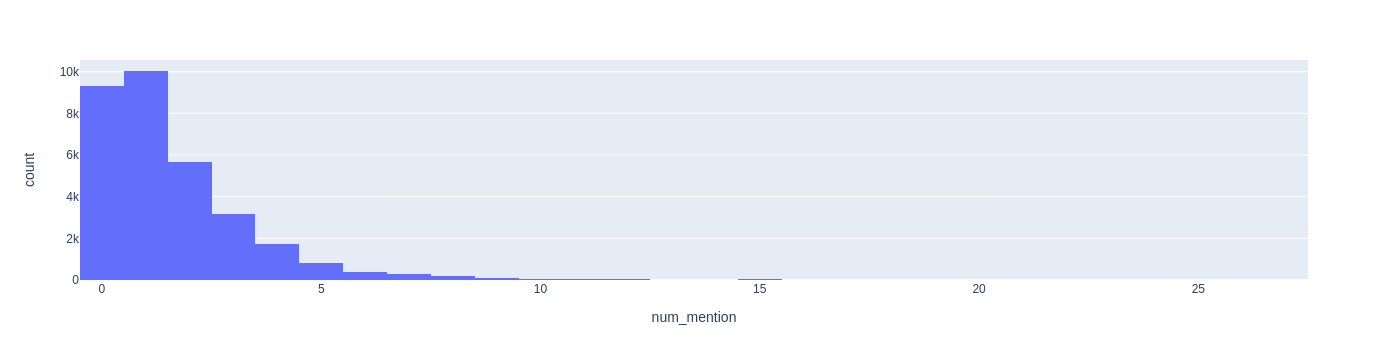

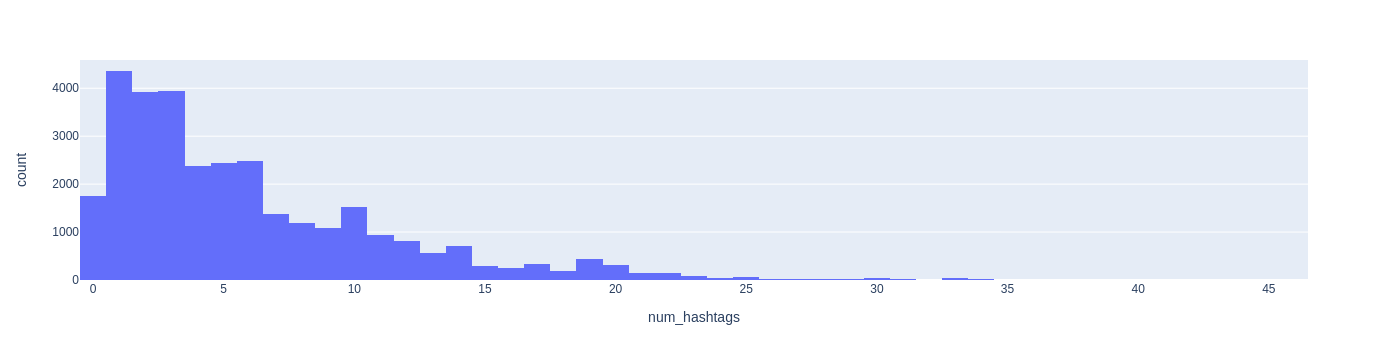

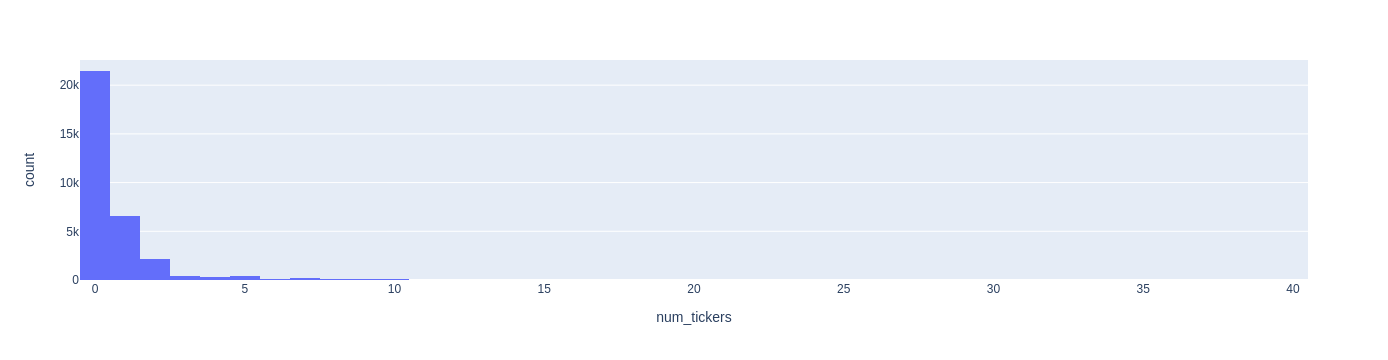

In [86]:
import plotly.express as px

fig = px.histogram(no_duplicates, x="num_mention")
fig.show()

fig = px.histogram(no_duplicates, x="num_hashtags")
fig.show()

fig = px.histogram(no_duplicates, x="num_tickers")
fig.show()

Remove some tweets that contain too many mentions/hastags/tickers since these are likely bots.

In [85]:
filter_query = "num_tickers <= 3 and num_hashtags <= 15 and num_mention <= 3"

filtered_data = no_duplicates.query(filter_query)

len(no_duplicates), len(filtered_data)

(31924, 24893)

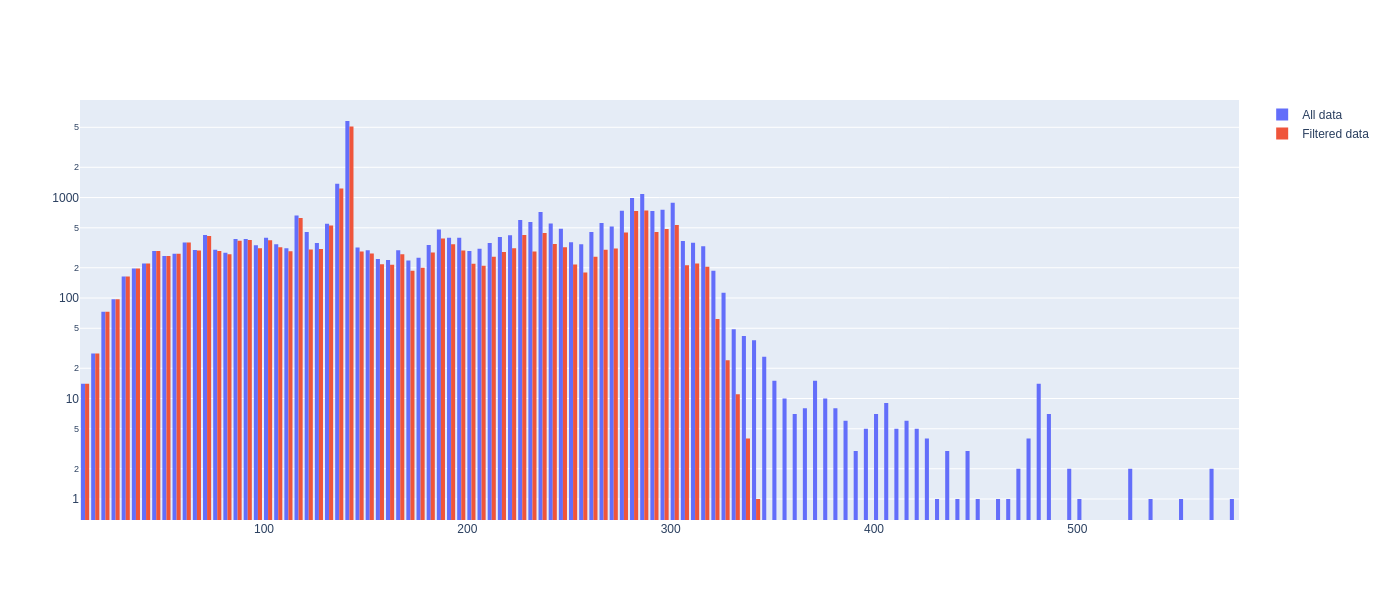

In [129]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Histogram(
        x=no_duplicates.length,
        name="All data"
        ),
    go.Histogram(
        x=filtered_data.length,
        name="Filtered data"
        )
    ]
)
fig.update_yaxes(type="log")
fig.update_layout(width=1200, height=600)
fig.show()

In [94]:
filtered_data.groupby("coin").mean()

,tweet_id,retweet_count,reply_count,like_count,quote_count,length,num_mention,num_hashtags,num_tickers
coin,,,,,,,,,
BTC,1.456429e+18,42.051200,0.270919,1.048420,0.016091,175.836015,1.005559,5.230837,0.437244
CRO,1.455874e+18,7.792017,1.030462,5.209821,0.066964,127.222952,0.755515,3.356880,0.436975
DOGE,1.456443e+18,43.001934,0.215280,1.059574,0.016828,189.714894,1.264410,5.358221,0.387041
ETH,1.456436e+18,91.373273,0.261743,0.900528,0.047476,193.772670,1.327054,4.771163,0.264506
SHIB,1.456410e+18,68.604551,0.168105,1.013731,0.016085,161.656924,1.408395,4.118478,0.399568


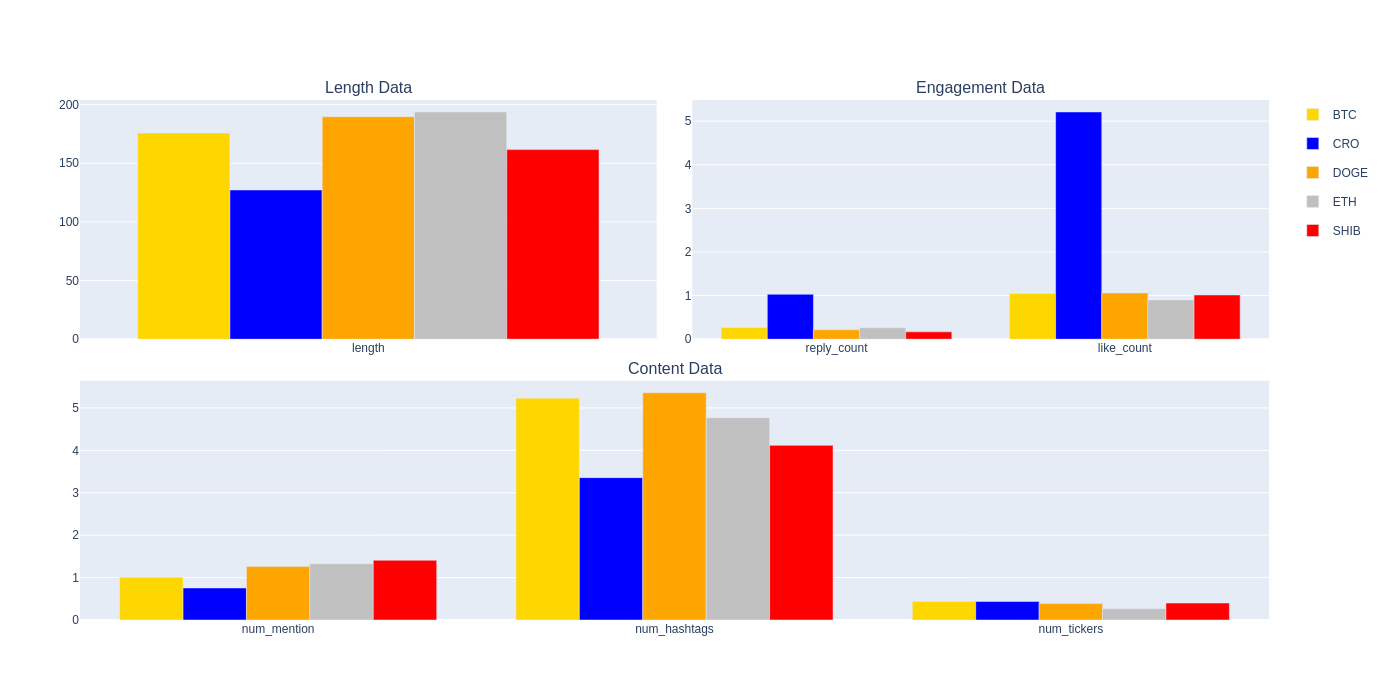

In [125]:
from plotly.subplots import make_subplots

engagement_columns = ["reply_count", "like_count"]
content_columns = ["num_mention", "num_hashtags", "num_tickers"]
meta_columns = ["length"]

coin_means = filtered_data.groupby("coin").mean()

coin_colors = {
    "BTC": "gold",
    "ETH": "silver",
    "CRO": "blue",
    "DOGE": "orange",
    "SHIB": "red"
}

engagement_data = []
content_data = []
meta_data = []

fig = make_subplots(
    rows=2, cols=2,
    horizontal_spacing=0.03,
    vertical_spacing=0.08,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Length Data", "Engagement Data", "Content Data"))

for coin in coin_means.index.values:  
    fig.add_trace(go.Bar(name=coin, x=meta_columns, y=coin_means.loc[coin, meta_columns].values, legendgroup=coin, marker_color=coin_colors[coin]),
                     row=1, col=1)

    fig.add_trace(go.Bar(name=coin, x=engagement_columns, y=coin_means.loc[coin, engagement_columns].values, legendgroup=coin, showlegend=False, marker_color=coin_colors[coin]),
                     row=1, col=2)

    fig.add_trace(go.Bar(name=coin, x=content_columns, y=coin_means.loc[coin, content_columns].values, legendgroup=coin, showlegend=False, marker_color=coin_colors[coin]),
                     row=2, col=1)

fig.update_layout(barmode='group', width=1200, height=700)
fig.show()

In [131]:
filtered_data.to_parquet("/home/mpecovnik/Private/sentiment-analysis/data/filtered_tweet_data.parquet")